In [1]:
import torch
import gpytorch
import numpy as np
import optuna
from src.plotting import plot_gp, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ApproximateGPBaseModel
from src.hyperparameter_tuning import HyperParameterOptimization
from src.beta_likelihood import BetaLikelihood_MeanParametrization

In [20]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 30
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 6
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 4
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6
NUM_LATENTS = 1
NUM_INDUCING = 100

==> Loading data
==> Loaded data in: 0 m : 6 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



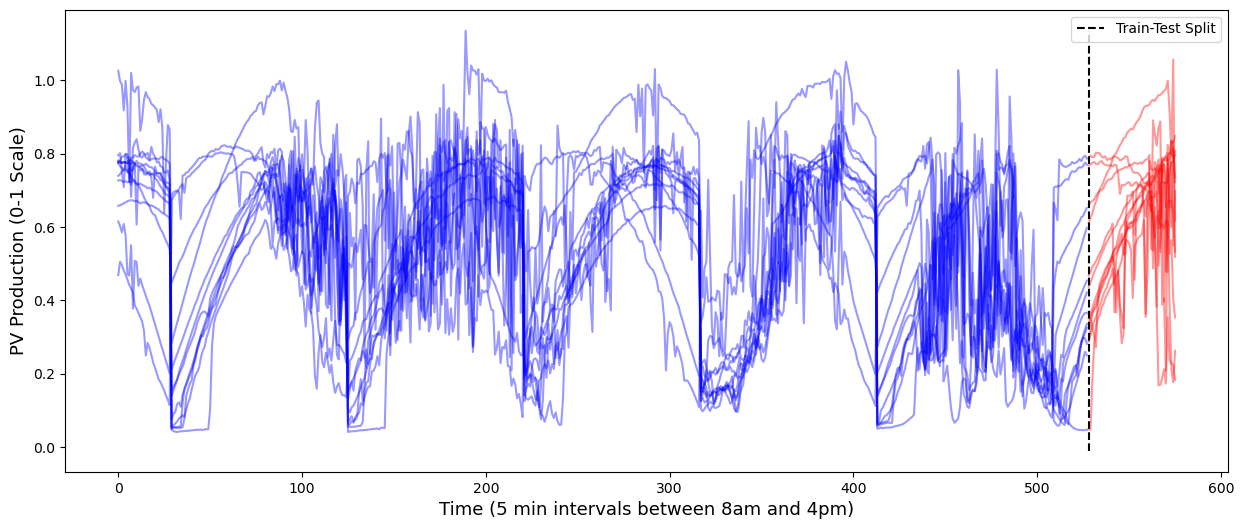

In [21]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL)
time = torch.stack([time, periodic_time], dim=-1)

x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [22]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import (VariationalStrategy, 
                                  CholeskyVariationalDistribution, 
                                  LMCVariationalStrategy, 
                                  IndependentMultitaskVariationalStrategy)
from src.variational_dist import VariationalBase


class MultiTaskBetaGP(ApproximateGP):
    """ 
    Base model for performing inference with a Multitask Gaussian Process (GP) using
    stochastic variational inference (SVI). The model has several outputs and a 
    Beta likelihood is used for each output to account for bounded data.
    """
    def __init__(self,
                 X : torch.Tensor,
                 y : torch.Tensor,
                 likelihood : gpytorch.likelihoods.Likelihood,
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 variational_strategy : str,
                 config : dict,
                 num_latents : int,
                 jitter : float = 1e-4,
                 learn_inducing_locations : bool = False
                 ):
        if isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
            assert y.min() >= 0 and y.max() <= 1, 'y must be in the range [0, 1] for Beta likelihood'
        
        assert X.size(0) == y.size(0), 'X and y must have same number of data points'
        assert variational_strategy in ['lmc', 'mt_indep'], 'Variational strategy must be either lmc or mt_indep'

        # add perturbation to the data to avoid numerical issues for bounded outputs
        if y.min() == 0:
            y += jitter
        
        if y.max() == 1:
            y -= jitter
        
        self.X = X
        self.y = y
        
        variational_dist = VariationalBase(config).variational_distribution
        
        base_variational = VariationalStrategy( self,
                                                inducing_points=X,
                                                variational_distribution=variational_dist,
                                                learn_inducing_locations=learn_inducing_locations,
                                                jitter_val=jitter)
        if variational_strategy == 'lmc':
            variational_strategy = LMCVariationalStrategy(base_variational_strategy=base_variational,
                                                          num_tasks=y.size(1),
                                                          num_latents=num_latents,
                                                          jitter_val=jitter)
        
        elif variational_strategy == 'mt_indep':
            variational_strategy = IndependentMultitaskVariationalStrategy(base_variational_strategy=base_variational,
                                                                           num_tasks=y.size(1),
                                                                         )

        super().__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = likelihood
    
    def forward(self, x, **kwargs):
        """ 
        Forward pass through the model
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    def predict(self, X, device : torch.device):
        """ 
        Make predictions with the model
        """
        self.to(device)
        
        self.eval()
        self.likelihood.eval()

        if not isinstance(self.likelihood, gpytorch.likelihoods.GaussianLikelihood):
                with gpytorch.settings.num_likelihood_samples(30):
                    # TODO if beta likelihood then predict using the mode
                    # the mode should give the most likely value for the prediction
                    preds = self.likelihood(self(X)) 
        else:
            preds = self.likelihood(self(X))
        
        return preds

    def get_inducing_points(self):
        """ 
        Get inducing points
        """
        return self.variational_strategy.inducing_points
    
    def fit(self,
            n_iter : int,
            lr : float,
            optim : torch.optim.Optimizer,
            device : torch.device,
            verbose : bool = True
            ):
        """
        Fit the model using SVI
        """
        self.to(device)
        
        self.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(self.variational_parameters(), lr=lr)
        
        elbo = gpytorch.mlls.VariationalELBO(self.likelihood, self, num_data=self.y.size(0))

        print_freq = n_iter // 10
        self.losses = []

        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            print(output.shape)
            loss = -elbo(output, self.y).mean()
            loss.backward()
            optimizer.step()

            self.losses.append(loss.item())

            if verbose and (i+1) % print_freq == 0:
                print(f'Iter({i+1}/{n_iter}) - Loss: {loss.item():.3f}')

In [23]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=y_train.size(-1)
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=y_train.size(-1), rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y_train.size(-1))

In [24]:
model = MultitaskGPModel(x_train, y_train, likelihood)

In [25]:
# Find optimal model hyperparameters
n_iter = 150
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(n_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/150 - Loss: 1.434
Iter 2/150 - Loss: 1.377
Iter 3/150 - Loss: 1.323
Iter 4/150 - Loss: 1.271
Iter 5/150 - Loss: 1.221
Iter 6/150 - Loss: 1.172
Iter 7/150 - Loss: 1.125
Iter 8/150 - Loss: 1.079
Iter 9/150 - Loss: 1.034
Iter 10/150 - Loss: 0.988
Iter 11/150 - Loss: 0.942
Iter 12/150 - Loss: 0.894
Iter 13/150 - Loss: 0.844
Iter 14/150 - Loss: 0.793
Iter 15/150 - Loss: 0.741
Iter 16/150 - Loss: 0.690
Iter 17/150 - Loss: 0.639
Iter 18/150 - Loss: 0.587
Iter 19/150 - Loss: 0.534
Iter 20/150 - Loss: 0.481
Iter 21/150 - Loss: 0.429
Iter 22/150 - Loss: 0.380
Iter 23/150 - Loss: 0.331
Iter 24/150 - Loss: 0.283
Iter 25/150 - Loss: 0.234
Iter 26/150 - Loss: 0.183
Iter 27/150 - Loss: 0.132
Iter 28/150 - Loss: 0.081
Iter 29/150 - Loss: 0.029
Iter 30/150 - Loss: -0.022
Iter 31/150 - Loss: -0.074
Iter 32/150 - Loss: -0.124
Iter 33/150 - Loss: -0.173
Iter 34/150 - Loss: -0.220
Iter 35/150 - Loss: -0.268
Iter 36/150 - Loss: -0.316
Iter 37/150 - Loss: -0.363
Iter 38/150 - Loss: -0.410
Iter 39/150 

In [26]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_train = likelihood(model(x_train))
    preds_test = likelihood(model(x_test))


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


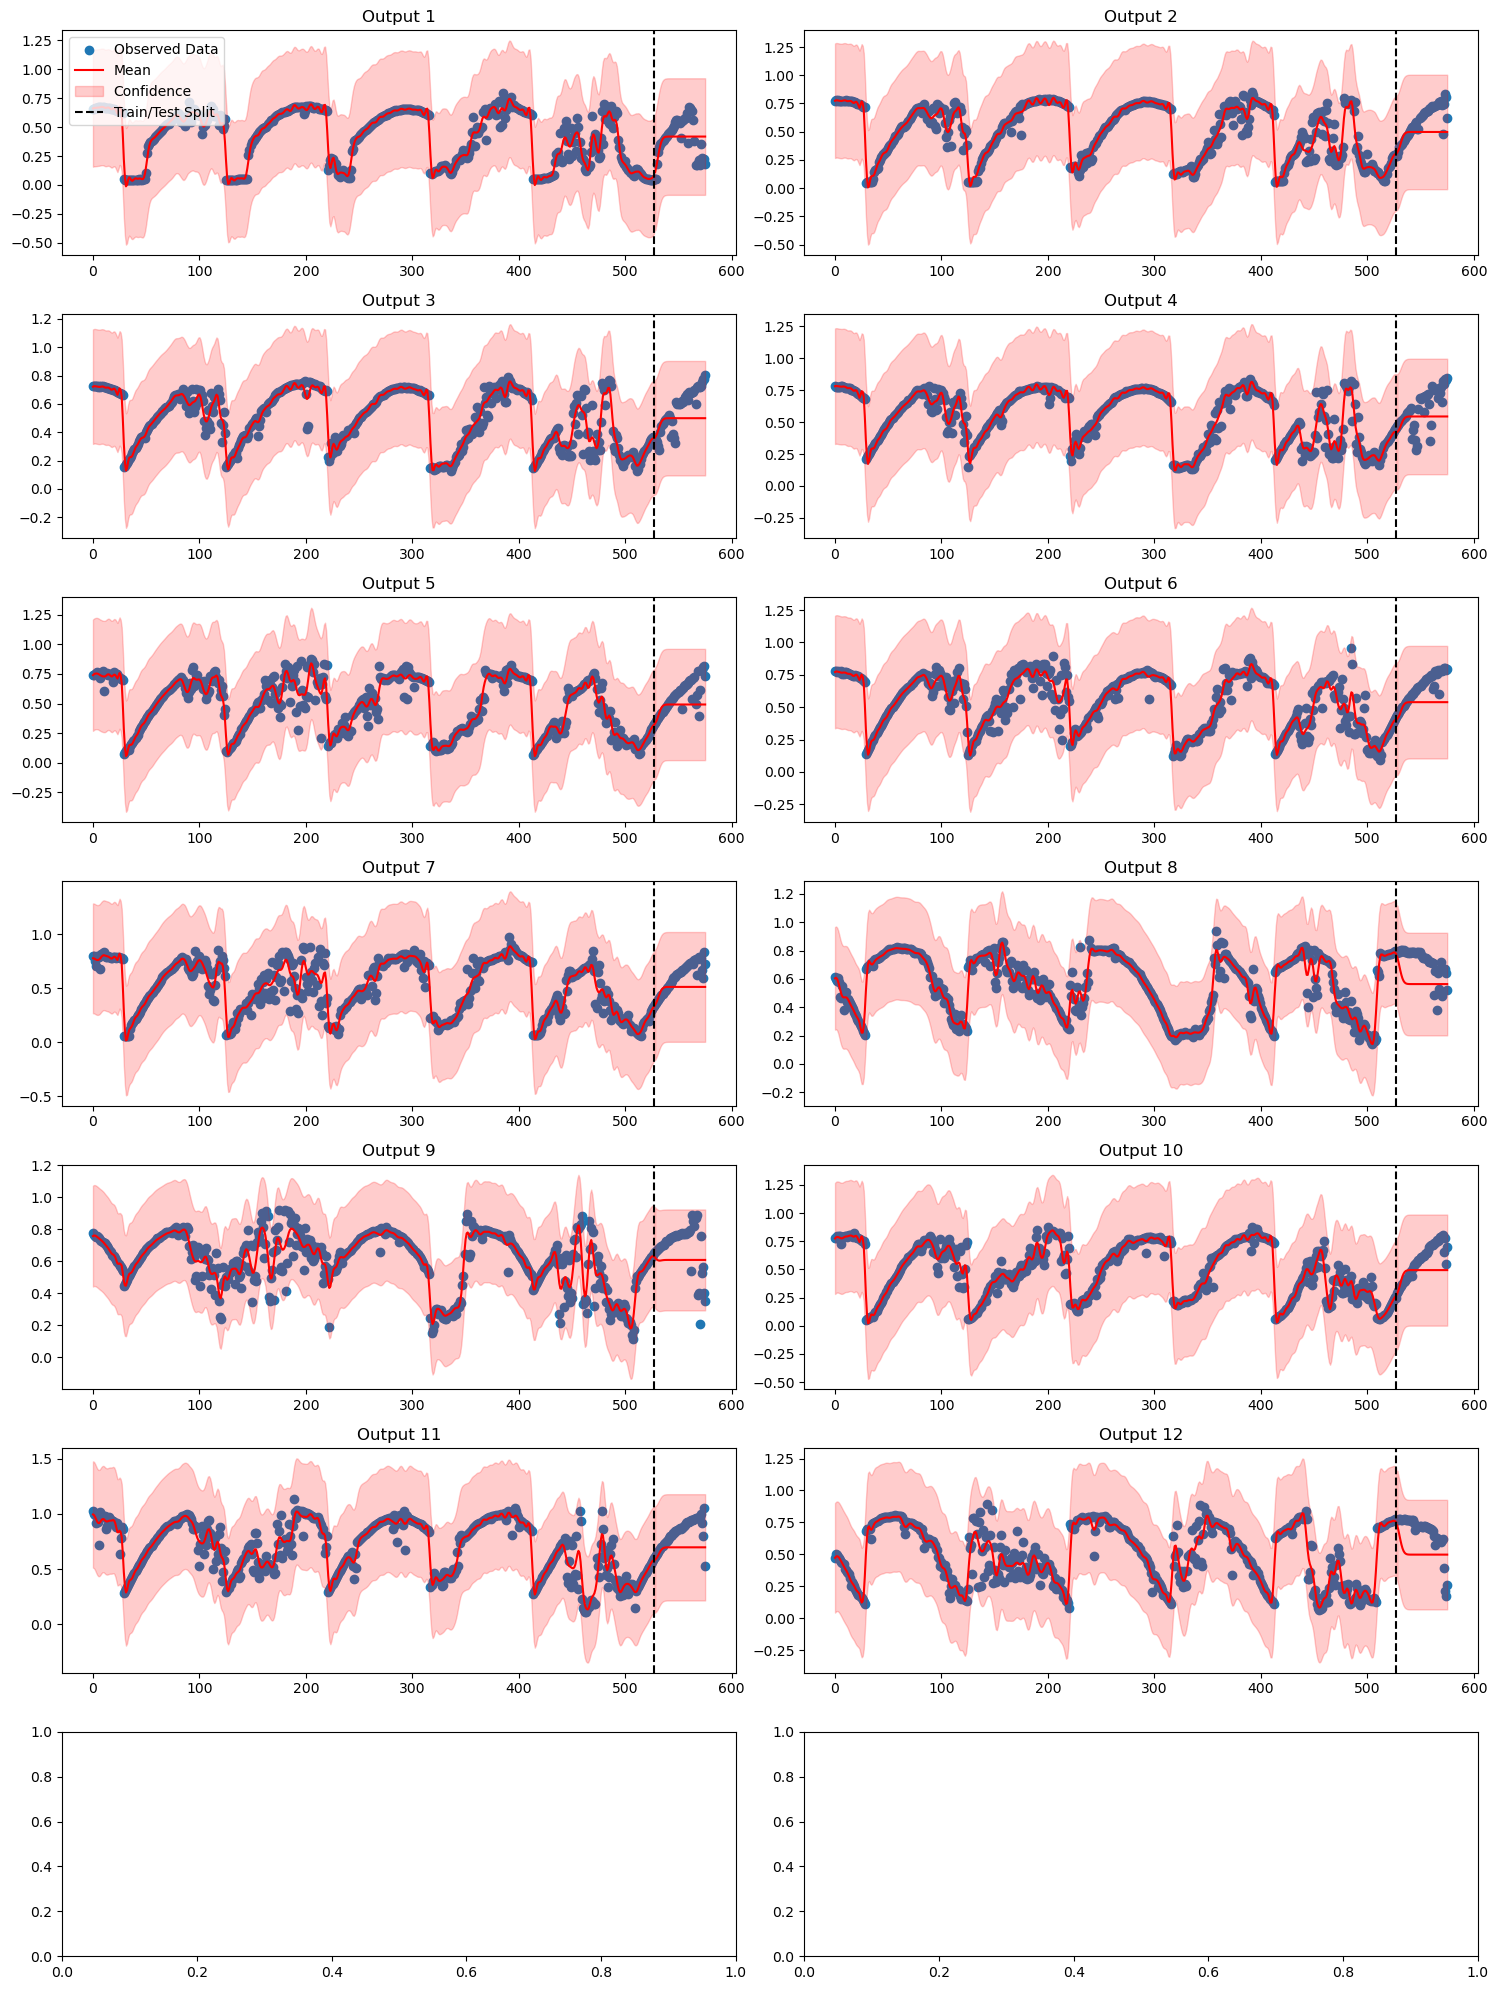

In [27]:
# plot all the outputs in a 6x2 + 1 grid
from matplotlib import pyplot as plt

fig, axs = plt.subplots(7, 2, figsize=(15, 20))
axs = axs.flatten()
with torch.no_grad():
    lower_train, upper_train = preds_train.confidence_region()
    lower_test, upper_test = preds_test.confidence_region()

for i in range(y_train.size(-1)):
    axs[i].scatter(time[:,0], y[:, i], label='Observed Data')
    axs[i].plot(x_train[:,0], preds_train.mean[:, i], 'r')
    axs[i].fill_between(x_train[:,0], lower_train[:, i], upper_train[:, i], alpha=0.2, color='r')
    axs[i].plot(x_test[:,0], preds_test.mean[:, i], 'r', label='Mean')
    axs[i].fill_between(x_test[:,0], lower_test[:, i], upper_test[:, i], alpha=0.2, label='Confidence', color='r')
    axs[i].axvline(x=x_train[:,0].max(), color='k', linestyle='--', label='Train/Test Split')
    axs[i].set_title(f'Output {i+1}')
    if i == 0:
        axs[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
num_latents = y_train.size(-1)

NameError: name 'y_train' is not defined

In [ ]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 16, 1)
        
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )
        
        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=4,
            num_latents=3,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel()